Accuracy on training data: 1.0
Accuracy on test data: 0.8717948717948718
LIME Explanation:
[('spread1 <= -0.71', -0.1149569660059986), ('MDVP:Fhi(Hz) > 0.28', -0.10442596834478679), ('MDVP:Fo(Hz) > 0.64', -0.06145586125454589), ('MDVP:Flo(Hz) > 0.58', -0.06089243132317168), ('0.07 < DFA <= 0.78', 0.05412094597647947)]


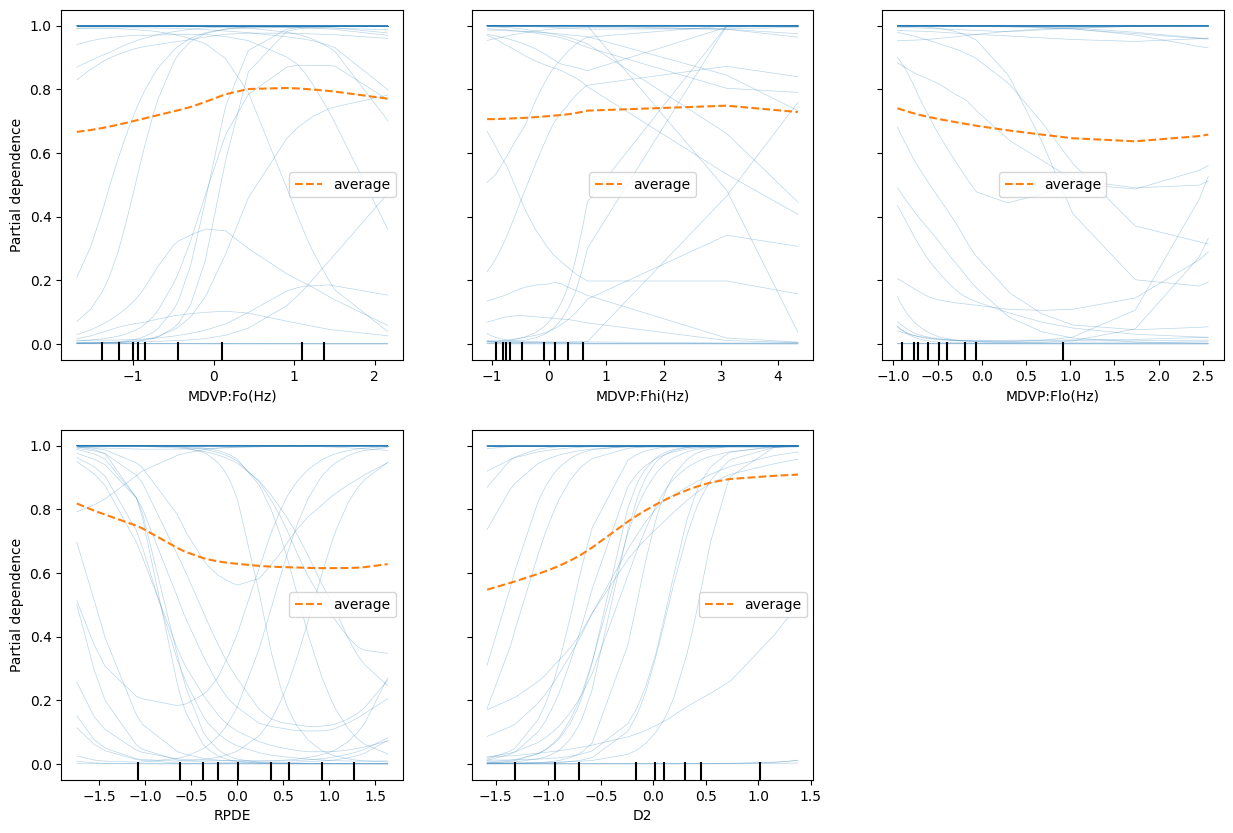

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import pickle
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Load CSV data into a pandas DataFrame
parkinsons_data = pd.read_csv(r"C:\Users\Ramachandra\OneDrive\Desktop\6th sem miniproject\parkinsons (1).csv")

# Split features and target
X = parkinsons_data.drop(columns=['name', 'status'], axis=1)
Y = parkinsons_data['status']

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize MLPClassifier with modified parameters
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(150, 75, 25),  # Adjusted hidden layer sizes
    activation='relu',  # Changed activation function
    alpha=0.001,  # Adjusted regularization strength
    solver='adam',  # Changed optimizer
    max_iter=1000,  # Increased max iterations
    random_state=2,
)

# Train MLP classifier with modified parameters
mlp_classifier.fit(X_train_scaled, Y_train)

# Model evaluation using accuracy score
train_accuracy = accuracy_score(Y_train, mlp_classifier.predict(X_train_scaled))
test_accuracy = accuracy_score(Y_test, mlp_classifier.predict(X_test_scaled))

print("Accuracy on training data:", train_accuracy)
print("Accuracy on test data:", test_accuracy)

# Save the MLP model using pickle
filename = 'parkinsons_mlp_model.sav'
pickle.dump(mlp_classifier, open(filename, 'wb'))

# Create a LimeTabularExplainer
explainer = LimeTabularExplainer(X_train_scaled, feature_names=X.columns.tolist(), class_names=['Healthy', 'Parkinsons'])

# Example input data
input_data = np.array([197.07600, 206.89600, 192.05500, 0.00289, 0.00001, 0.00166, 0.00168, 0.00498, 0.01098, 0.09700, 0.00563, 0.00680, 0.00802, 0.01689, 0.00339, 26.77500, 0.422229, 0.741367, -7.348300, 0.177551, 1.743867, 0.085569]).reshape(1, -1)

# Generate explanations for a single instance
exp = explainer.explain_instance(input_data[0], mlp_classifier.predict_proba, num_features=5)

print('LIME Explanation:')
print(exp.as_list())
exp.show_in_notebook()

# PDP and ICE plots using sklearn.inspection
features_to_plot = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'RPDE', 'D2']

# Plot PDP and ICE for selected features
fig, ax = plt.subplots(figsize=(15, 10))
display = PartialDependenceDisplay.from_estimator(
    mlp_classifier, 
    X_test_scaled, 
    features=features_to_plot, 
    feature_names=X.columns, 
    kind="both",  # plot both PDP and ICE
    ax=ax
)
plt.show()

LIME (Local Interpretable Model-agnostic Explanations) provides explanations for individual predictions made by a machine learning model. It approximates the complex model with a simpler, interpretable model (such as a linear regression) in the locality of the instance being explained. Here’s a step-by-step breakdown of what the LIME output means and how to interpret it:

### Explanation Breakdown:
1. **Instance Explanation:**
   - LIME generates an explanation for a single instance (observation) by perturbing the data and seeing how the predictions change. This process builds a local, interpretable model around the prediction for that instance.

2. **Feature Contributions:**
   - The output includes a list of features along with their respective contributions to the prediction. These contributions are usually represented as weights or coefficients in the linear model that LIME fits locally around the instance.

3. **Sign and Magnitude:**
   - **Positive Contribution:** A positive weight indicates that the feature contributes positively to the prediction (i.e., it increases the predicted probability of the target class).
   - **Negative Contribution:** A negative weight indicates that the feature contributes negatively to the prediction (i.e., it decreases the predicted probability of the target class).
   - **Magnitude:** The magnitude of the weight shows the strength of the feature's contribution. Larger absolute values indicate more significant contributions.

### Example LIME Output Interpretation:
Suppose the LIME output for a particular instance looks like this:

```plaintext
LIME Explanation:
[('MDVP:Fo(Hz) > 150', 0.25),
 ('MDVP:Jitter(%) < 0.01', -0.15),
 ('RPDE > 0.4', 0.1),
 ('DFA < 0.6', -0.05),
 ('spread1 > -5', 0.05)]
```

- **Instance:** The explanation is for a specific instance with certain values for each feature.
- **Contributions:** Each tuple in the list represents a feature and its contribution to the prediction.
- **Feature Conditions:**
  - `'MDVP:Fo(Hz) > 150'` contributes positively (0.25) to the prediction, suggesting that a higher fundamental frequency increases the likelihood of the predicted class (e.g., Parkinson's).
  - `'MDVP:Jitter(%) < 0.01'` contributes negatively (-0.15), indicating that lower jitter decreases the likelihood of the predicted class.
  - `'RPDE > 0.4'` contributes positively (0.1), suggesting that a higher RPDE value slightly increases the likelihood of the predicted class.
  - `'DFA < 0.6'` contributes negatively (-0.05), indicating that a lower DFA value slightly decreases the likelihood of the predicted class.
  - `'spread1 > -5'` contributes positively (0.05), suggesting that a larger spread1 value slightly increases the likelihood of the predicted class.

### Overall Prediction:
- The sum of these contributions (weights) and the intercept of the local linear model give the final prediction for the instance. LIME helps us understand which features and their specific values led to the model’s decision.

### Visualization:
- **Bar Charts:** LIME often visualizes feature contributions using bar charts. Each bar represents a feature's contribution, with the length indicating the magnitude and the direction indicating whether it's positive or negative.
- **Heatmaps:** Heatmaps can also be used to show contributions of features across multiple instances, highlighting patterns and important features.

### Use Cases:
- **Model Debugging:** Identifying which features are most influential for specific predictions can help in debugging and improving the model.
- **Trust and Transparency:** Providing explanations increases trust in the model, especially in high-stakes areas like healthcare, finance, or law.
- **Feature Engineering:** Insights from LIME can guide feature engineering by highlighting important features and potential interactions.

In summary, LIME breaks down the complex decision-making process of a model for a specific instance, showing which features contributed to the prediction and how. This helps in understanding, debugging, and trusting machine learning models.

The graphs generated by `PartialDependenceDisplay.from_estimator` help interpret the influence of individual features on the model's predictions. Specifically, they show Partial Dependence Plots (PDP) and Individual Conditional Expectation (ICE) plots for the selected features. Here's what each type of plot represents:

### Partial Dependence Plots (PDP):
1. **Purpose:**
   - PDPs show the average effect of a feature (or features) on the predicted outcome of the model. They provide insights into the relationship between the feature values and the predicted probability of the target variable.

2. **Interpretation:**
   - The PDP curve is created by averaging the predictions of the model over all observations, while varying the feature of interest. This helps understand how changes in the feature impact the prediction on average.
   - A flat line indicates that the feature has little to no effect on the prediction.
   - An upward sloping line indicates a positive relationship between the feature value and the predicted outcome.
   - A downward sloping line indicates a negative relationship between the feature value and the predicted outcome.

### Individual Conditional Expectation (ICE) Plots:
1. **Purpose:**
   - ICE plots show the individual effects of a feature on the predicted outcome for each observation in the dataset. They provide a more granular view of the feature's influence compared to PDPs.

2. **Interpretation:**
   - Each line in an ICE plot represents how the predicted outcome changes for an individual observation as the feature value varies.
   - If the lines are parallel and follow a similar trend, it suggests that the feature has a consistent effect on the prediction across all observations.
   - If the lines are not parallel and show different trends, it indicates that the feature's effect varies among different observations, suggesting potential interaction effects with other features.

### Combined PDP and ICE:
- When both PDP and ICE plots are shown together, it provides a comprehensive view:
  - The PDP curve (typically in a bold line) shows the average effect.
  - The ICE lines show the individual effects, highlighting variability among observations.

### Example Interpretation of Selected Features:
Let's go through a hypothetical interpretation of the features you've chosen to plot: `['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'RPDE', 'D2']`.

1. **MDVP:Fo(Hz):**
   - **PDP:** If the PDP curve for `MDVP:Fo(Hz)` slopes upwards, it indicates that higher fundamental frequencies are associated with a higher likelihood of Parkinson's.
   - **ICE:** If the ICE lines are mostly parallel, it confirms a consistent effect across observations. Divergent lines would suggest varying impacts on predictions for different individuals.

2. **MDVP:Fhi(Hz):**
   - **PDP:** An upward or downward slope in the PDP indicates how high-frequency measurements relate to the predicted status of Parkinson's.
   - **ICE:** The pattern of ICE lines will reveal whether this relationship holds consistently across individuals.

3. **MDVP:Flo(Hz):**
   - **PDP and ICE:** Similar interpretation as above, focusing on the lowest frequency measurements.

4. **RPDE:**
   - **PDP:** Reveals how the recurrence period density entropy (a measure of signal complexity) influences the model's predictions.
   - **ICE:** Highlights individual variability in this relationship.

5. **D2:**
   - **PDP:** Shows the effect of the correlation dimension (another measure of signal complexity) on the prediction.
   - **ICE:** Provides insight into individual differences in the effect of `D2` on the prediction.

### Summary:
These plots help to demystify the "black-box" nature of neural networks by visually showing how specific features impact the model's predictions. They can guide feature selection, model validation, and provide insights into the underlying data relationships.

Accuracy on training data: 1.0
Accuracy on test data: 0.8717948717948718
LIME Explanation:
[('spread1 <= -0.71', -0.13915239772693558), ('MDVP:Fhi(Hz) > 0.28', -0.09530387912235926), ('0.07 < DFA <= 0.78', 0.06113121296245447), ('MDVP:Fo(Hz) > 0.64', -0.05405463173541539), ('MDVP:Flo(Hz) > 0.58', -0.052920558569801546)]


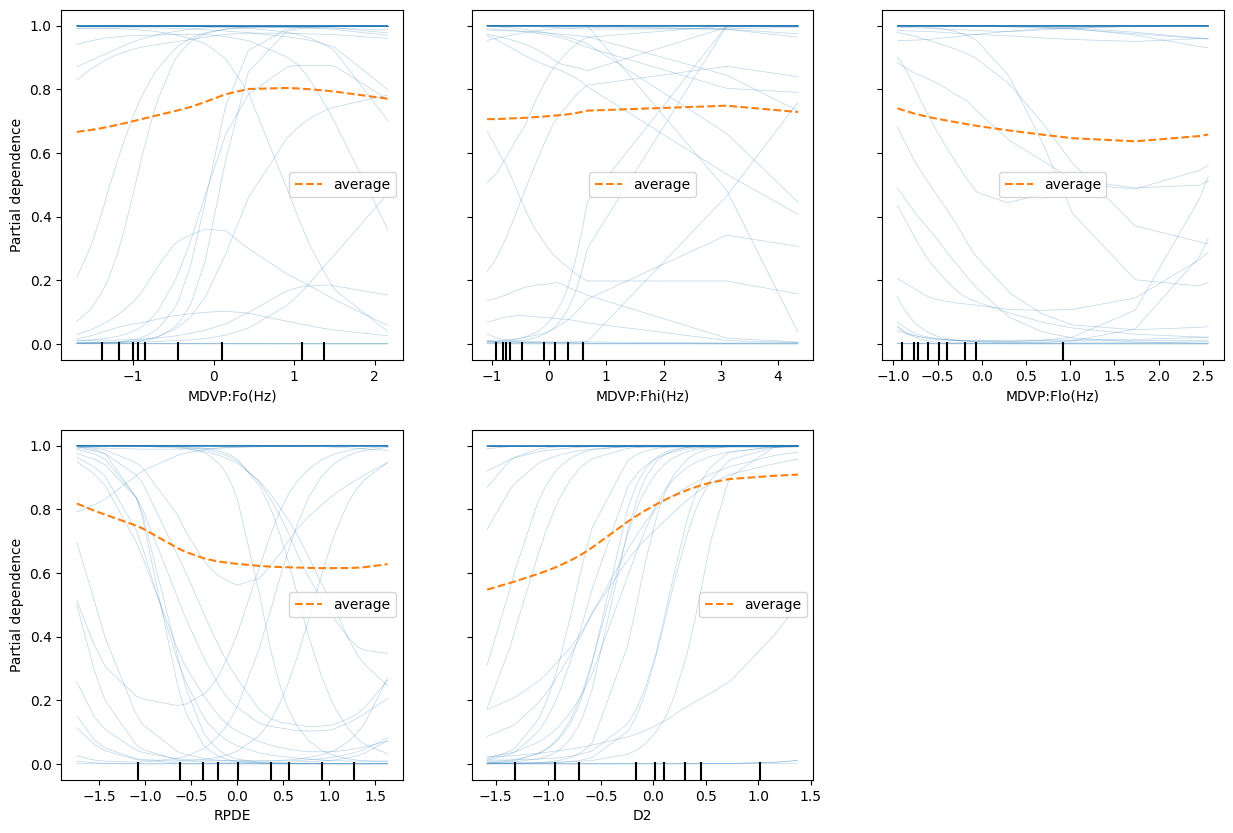

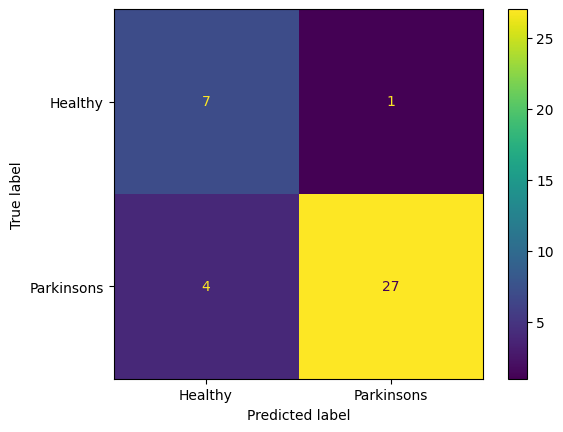

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import pickle
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Load CSV data into a pandas DataFrame
parkinsons_data = pd.read_csv(r"C:\Users\Ramachandra\OneDrive\Desktop\6th sem miniproject\parkinsons (1).csv")

# Split features and target
X = parkinsons_data.drop(columns=['name', 'status'], axis=1)
Y = parkinsons_data['status']

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize MLPClassifier with modified parameters
mlp_classifier = MLPClassifier(
    hidden_layer_sizes=(150, 75, 25),  # Adjusted hidden layer sizes
    activation='relu',  # Changed activation function
    alpha=0.001,  # Adjusted regularization strength
    solver='adam',  # Changed optimizer
    max_iter=1000,  # Increased max iterations
    random_state=2,
)

# Train MLP classifier with modified parameters
mlp_classifier.fit(X_train_scaled, Y_train)

# Model evaluation using accuracy score
train_accuracy = accuracy_score(Y_train, mlp_classifier.predict(X_train_scaled))
test_accuracy = accuracy_score(Y_test, mlp_classifier.predict(X_test_scaled))

print("Accuracy on training data:", train_accuracy)
print("Accuracy on test data:", test_accuracy)

# Save the MLP model using pickle
filename = 'parkinsons_mlp_model.sav'
pickle.dump(mlp_classifier, open(filename, 'wb'))

# Create a LimeTabularExplainer
explainer = LimeTabularExplainer(X_train_scaled, feature_names=X.columns.tolist(), class_names=['Healthy', 'Parkinsons'])

# Example input data
input_data = np.array([197.07600, 206.89600, 192.05500, 0.00289, 0.00001, 0.00166, 0.00168, 0.00498, 0.01098, 0.09700, 0.00563, 0.00680, 0.00802, 0.01689, 0.00339, 26.77500, 0.422229, 0.741367, -7.348300, 0.177551, 1.743867, 0.085569]).reshape(1, -1)

# Generate explanations for a single instance
exp = explainer.explain_instance(input_data[0], mlp_classifier.predict_proba, num_features=5)

print('LIME Explanation:')
print(exp.as_list())
exp.show_in_notebook()

# PDP and ICE plots using sklearn.inspection
features_to_plot = ['MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'RPDE', 'D2']

# Plot PDP and ICE for selected features
fig, ax = plt.subplots(figsize=(15, 10))
display = PartialDependenceDisplay.from_estimator(
    mlp_classifier, 
    X_test_scaled, 
    features=features_to_plot, 
    feature_names=X.columns, 
    kind="both",  # plot both PDP and ICE
    ax=ax
)
plt.show()

# Draw confusion matrix
Y_pred = mlp_classifier.predict(X_test_scaled)
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Parkinsons'])
disp.plot()
plt.show()
